In [16]:
import cfp
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import jax
import jax.numpy as jnp
import optax
from omegaconf import DictConfig, OmegaConf
from functools import partial
from cfp.training import Metrics, PCADecoder, PCADecodedMetrics
from cfp.training._callbacks import WandbLogger
from ott.solvers import utils as solver_utils
from cfp.data._data import PredictionData, TrainingData, ValidationData
from cfp.data import TrainSampler


In [3]:
dataset_path = {
    "train": '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/ood_cell_type/IFNG_ct-BXPC3_hvg-2000_pca-30_norm/adata_train_IFNG_BXPC3_embs.h5ad',
    "test": '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/ood_cell_type/IFNG_ct-BXPC3_hvg-2000_pca-30_norm/adata_test_IFNG_BXPC3_embs.h5ad',
    "ood": '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/ood_cell_type/IFNG_ct-BXPC3_hvg-2000_pca-30_norm/adata_ood_IFNG_BXPC3_embs.h5ad'
}

model_config = {
    "hidden_dims": (1024, 1024, 1024),
    "decoder_dims": (2048, 2048, 2048),
    "condition_embedding_dim": 4096,
    "time_encoder_dims": (512, 512, 512),
    "flow": {"constant_noise": 1.0},
    "hidden_dropout": 0.0,
    "decoder_dropout": 0.0,
    "layers_after_pool": ({"layer_type": "mlp", "dims": (4096, 4096)},),
    "match_kwargs": {"epsilon": 0.01, "tau_a": 1.0, "tau_b": 0.999},
    #"covariates_not_pooled": ['cell_type', 'pathway', 'gene'],
}

train_config = {
    "learning_rate": 5.0e-05,
    "batch_size": 1024,
    "multi_steps": 50,
    "num_iterations": 1000000,
    "valid_freq": 1000,
    "n_test_samples": 2,
    "n_ood_samples": 2,
    "save_model": True,
    "save_model_path": "/home/icb/lea.zimmermann/projects/cell_flow_perturbation/results"
}
optimizer = optax.MultiSteps(optax.adam(learning_rate=train_config["learning_rate"]), train_config["multi_steps"])

match_fn = partial(solver_utils.match_linear, **model_config["match_kwargs"])

In [5]:
adata_train = sc.read_h5ad(dataset_path["train"])
adata_test = sc.read_h5ad(dataset_path["test"])
adata_ood = sc.read_h5ad(dataset_path["ood"])

In [10]:
cf = cfp.model.CellFlow(adata_train, solver='otfm')

In [11]:
cf.prepare_data(
    sample_rep="X_pca",  # this is the location of the cell data, can also be "X"
    control_key="control",  # Column to distinguish controls. could wither be a tuple with the column key and the control name or just the name of a boolian column
    sample_covariates=[
        'pathway',
        'cell_type'
    ],  # split the data based on the covariates in obs, such as "cell_type"
    split_covariates=['cell_type'],
    sample_covariate_reps={
        "cell_type": "cell_type_emb",
        "pathway": "pathway_emb",
    },  
    perturbation_covariates={'gene': ('gene',)},
    perturbation_covariate_reps={
        "gene": "gene_emb",
    }, 
)

/ictstr01/home/icb/lea.zimmermann/projects/cell_flow_perturbation/src/cfp/data/_datamanager.py:742: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[covariate] = adata.obs[covariate].astype("category")
/ictstr01/home/icb/lea.zimmermann/projects/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 218/218 [00:01<00:00, 145.96it/s]


In [12]:
# Then prepare validation data from separate adata object
cf.prepare_validation_data(
    adata_test,
    name="test",
    n_conditions_on_log_iteration=2,
    n_conditions_on_train_end=2
)
# If you have two, such as test & ood you can run it a second time
cf.prepare_validation_data(
    adata_ood,
    name="ood",
    n_conditions_on_log_iteration=2,
    n_conditions_on_train_end=2
)

/ictstr01/home/icb/lea.zimmermann/projects/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
  0%|          | 0/219 [00:00<?, ?it/s]

100%|██████████| 219/219 [00:00<00:00, 424.88it/s]
/ictstr01/home/icb/lea.zimmermann/projects/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 58/58 [00:00<00:00, 189.17it/s]


In [13]:
check_train_data = cf.dm.get_train_data(cf.adata)

/ictstr01/home/icb/lea.zimmermann/projects/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 218/218 [00:01<00:00, 112.74it/s]


In [25]:
train_sampler = TrainSampler(check_train_data, batch_size=1024)
rng_1 = jax.random.PRNGKey(0)
rng_2 = jax.random.PRNGKey(1)
rng_3 = jax.random.PRNGKey(2)
rng_4 = jax.random.PRNGKey(3)
sample_1 = train_sampler.sample(rng_1)
sample_2 = train_sampler.sample(rng_2)
sample_3 = train_sampler.sample(rng_3)
sample_4 = train_sampler.sample(rng_4)

In [29]:
all_pca_data = []
all_labels = []
all_sample_labels = []

for i, data_dict in enumerate([sample_1, sample_2, sample_3, sample_4]):
    all_pca_data.append(data_dict['src_cell_data'])
    all_labels.extend(['src'] * data_dict['src_cell_data'].shape[0])
    all_sample_labels.extend([f'sample_{i}'] * data_dict['src_cell_data'].shape[0])
    
    all_pca_data.append(data_dict['tgt_cell_data'])
    all_labels.extend(['target'] * data_dict['tgt_cell_data'].shape[0])
    all_sample_labels.extend([f'sample_{i}'] * data_dict['tgt_cell_data'].shape[0])

combined_pca_data = np.vstack(all_pca_data)
labels_df = pd.DataFrame({'label': all_labels, 'sample': all_sample_labels})
adata_recon = ad.AnnData(obs=labels_df)
adata_recon.obsm['X_pca'] = combined_pca_data

/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/ot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [30]:
sc.pp.neighbors(adata_recon, use_rep='X_pca')
sc.tl.umap(adata_recon)

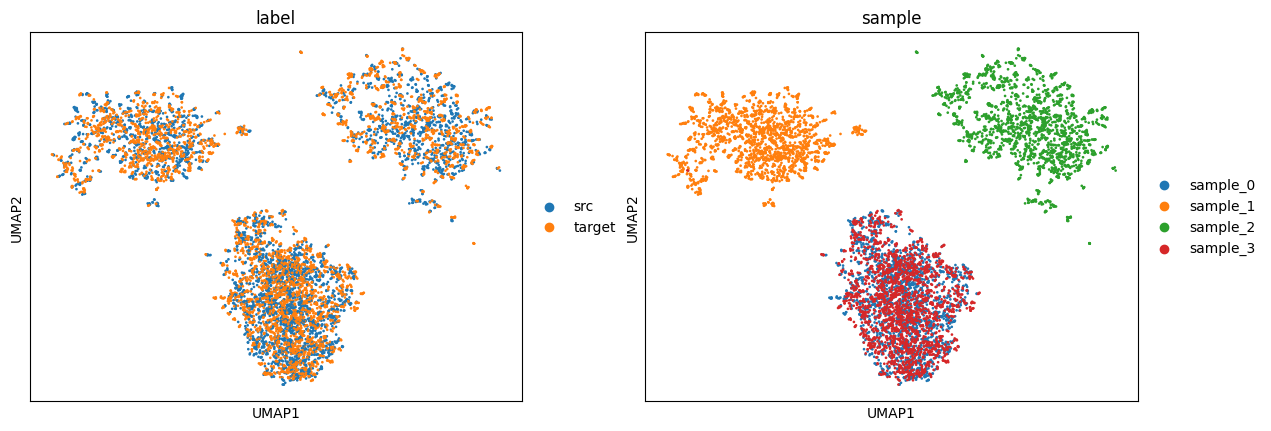

In [31]:
sc.pl.umap(adata_recon, color=["label", "sample"])